# DCGAN Implementation

Implementation of the (vanilla) Deep Convolutional Generative Adversarial Network defined by <a href="https://arxiv.org/pdf/1511.06434.pdf">Radford, Metz, and Chintala (2016)</a>.  Testing is done on the <a href="https://www.cs.toronto.edu/~kriz/cifar.html">CIFAR-10</a> benchmark image dataset, stored in pickled format in the `data/` directory.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from collections import OrderedDict
import pickle

In [2]:
# Print out the tensors currently allocated
import torch
import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(obj.device, type(obj), obj.size())
    except:
        pass

In [3]:
t = torch.cuda.get_device_properties(0).total_memory
c = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = c-a  # free inside cache

print(f"Total CUDA memory: {t / 10**9}")
print(f"Cached CUDA memory: {c/ 10**9}")
print(f"Allocated CUDA memory: {a/ 10**9}")
print(f"Free CUDA memory: {f / 10**9}")

Total CUDA memory: 6.442450944
Cached CUDA memory: 0.0
Allocated CUDA memory: 0.0
Free CUDA memory: 0.0


## Load CIFAR Data

In [4]:
# Helper functions to convert CIFAR-10 to Pytorch Dataset

def enpickle(obj, file):
    import pickle
    with open(file, 'wb') as out_file:
        pickle_dict = pickle.dump(obj, out_file)
    return pickle_dict

def unpickle(file):
    import pickle
    with open(file, 'rb') as in_file:
        pickle_dict = pickle.load(in_file, encoding='bytes')
    return pickle_dict


def read_data(file_name):
    """Given path to CIFAR data batch, returns raw X, y tensors."""
    
    batch_dict = unpickle(file_name)
    X_raw = torch.tensor(batch_dict[b'data'])
    y_raw = torch.tensor(batch_dict[b'labels']).long()
    return X_raw, y_raw


def shape_image(X):
    """Reshapes raw data tensor to nn.module-compatible RGB image"""
    
    # Each row of X_raw contains RGB color channels concatenated in row-major order
    # Need to first split channels into dim 1 on tensor, then shape dim 2/3 into image
    image_size = 32*32
    X = torch.split(X.unsqueeze(dim=1), image_size, dim=2)
    X = torch.cat(X, dim=1)
    X = X.view(-1, 3, 32, 32)   # (N, channels, pixel rows, pixel cols)
    return X


def normalize(X, a=-1, b=1):
    """Normalizes data tensor to [a, b] using min-max scaling."""
    
    data_min = torch.min(X).float().item()
    data_max = torch.max(X).float().item()
    assert a < b, "Rescaled range [a, b] must have a < b"
    
    # First scale to [0, 1], then rescale to [a, b]
    X = (X - data_min) / (data_max - data_min)
    X = (X * (b - a)) + a  
    return X


class CIFARDataset(torch.utils.data.Dataset):
    """Custom Dataset class which preprocesses and stores datasets
       from CIFAR batch files.  Works for CIFAR-10 and CIFAR-100."""
    
    def __init__(self, X=None, y=None):
        self.data = X
        self.labels = y
        
    def load(self, file_list):
        # Get list of (X, y) tuples, concatenate corresponding tensors
        combined_list = [read_data(file_name) for file_name in file_list]
        X_list, y_list = list(zip(*combined_list))
        X = torch.cat(X_list, dim=0)
        y = torch.cat(y_list, dim=0)
        
        self.data = normalize(shape_image(X))
        self.labels = y
        return self
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        # Generates an (X, y) pair at given index
        return self.data[index], self.labels[index]
    
    def cuda(self):
        if torch.cuda.is_available():
            device = torch.device("cuda:0")
            self.data = self.data.to(device)
            self.labels = self.labels.to(device)
            
    def cpu(self):
        self.data = self.data.cpu()
        self.labels = self.labels.cpu()

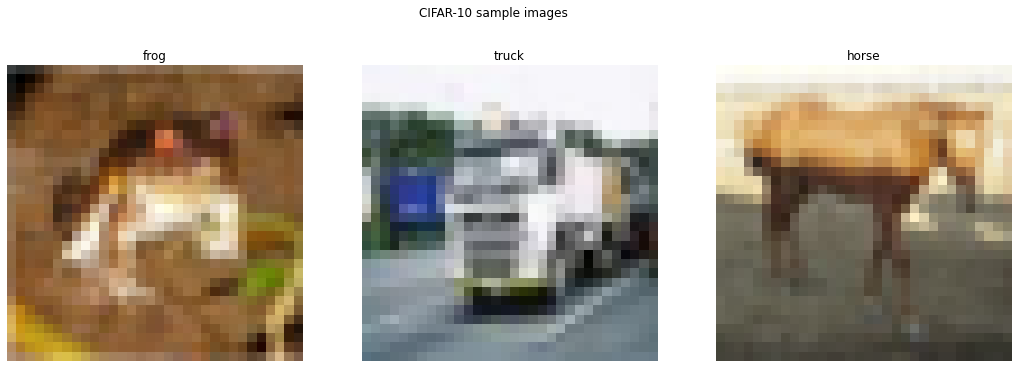

In [5]:
train_set = CIFARDataset().load([f"data/data_batch_{n}" for n in range(1, 6)])
test_set = CIFARDataset().load(["data/test_batch"])
cifar_meta = unpickle("data/batches.meta")

# Visualize a few random examples
def plot_image(x, ax):
    """Helper to scale and plot output from ImageDataset."""
    image = (x.squeeze().permute(1, 2, 0) + 1) / 2
    ax.imshow(image.clone().cpu().detach())
    ax.axis("off")
    
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for i in range(3):
    X, y = train_set[i*1000]
    plot_image(X, ax[i])
    ax[i].set_title(cifar_meta[b'label_names'][y.item()].decode('ascii'))
plt.suptitle("CIFAR-10 sample images")
plt.show()

## DCGAN Architecture

In [6]:
# Define architecture for vanilla generator and discriminator
# See also:
# https://gluon.mxnet.io/chapter14_generative-adversarial-networks/dcgan.html
# https://wandb.ai/sairam6087/dcgan/reports/DCGAN-on-CIFAR-10--Vmlldzo5NjMyOQ
# https://github.com/soumith/ganhacks

def conv_block(which_model, conv_args=[], conv_kwargs={'bias': False},
               leak_slope=0.2, batch_norm=True, activation=True):
    """Performs all the operations in a single DCGAN layer in the following order:
       batch normalization -> convolution (optional) -> nonlinearity (optional)
       
       If which == 'gen', does a transpose convolution
       If which == 'dis', does a normal convolution
       Returns a list of functions in order; should unpack and fill in nn.Sequential"""
    
    funcs = []
    
    if which_model == 'gen':
        funcs.append(nn.ConvTranspose2d(*conv_args, **conv_kwargs))
        if batch_norm:
            funcs.append(nn.BatchNorm2d(conv_args[1]))
        if activation:
            funcs.append(nn.ReLU(inplace=True))
            
    elif which_model == 'dis':
        funcs.append(nn.Conv2d(*conv_args, **conv_kwargs))
        if batch_norm:
            funcs.append(nn.BatchNorm2d(conv_args[1]))
        if activation:
            funcs.append(nn.LeakyReLU(leak_slope, inplace=True))
            
    else:
        raise ValueError("Argument `which_model` is not a valid value")
        
    # Initialize the weights to match DCGAN paper?
    # Build a list of the three functions in sequence
    return funcs
    

class OldDCGenerator(nn.Module):
    """Deep convolutional generator which maps latent noise vector -> (32,32) RGB-channel image.
       The latent space input z is projected and convolved with many feature maps.
       Subsequent layers use only fractional-strided convolutions (no pooling).
       All hidden layers use ReLU activation, and output layer uses tanh."""
    
    def __init__(self, z_len=100):
        
        super(OldDCGenerator, self).__init__()
        self.z_len = z_len
        
        self.in_layer = nn.Linear(z_len, 128 * 4 * 4)
        
        # Choose kernel_size, stride, padding to double height/width for each layer
        self.conv_layers = nn.Sequential(
            #*conv_block('gen', [z_len, 128, 4, 1, 0]),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            *conv_block('gen', [128, 128, 4, 2, 1]),
            *conv_block('gen', [128, 128, 4, 2, 1]),
            *conv_block('gen', [128, 3, 4, 2, 1], batch_norm=False, activation=False),
            nn.Tanh()
        )
    
    def forward(self, z):
        # Reshape z as 4d tensor
        z = self.in_layer(z).view(-1, 128, 4, 4)
        return self.conv_layers(z)


class OldDCDiscriminator(nn.Module):
    """Deep convolutional discriminator which maps (32,32) RGB-channel image -> [0, 1].
       The image is passed through several convolutional layers (again, no pooling).
       All hidden layers use LeakyReLU activation, and output layer uses sigmoid."""
    
    def __init__(self, leak_slope=0.2):
        
        super(OldDCDiscriminator, self).__init__()
        
        # Just reverse the convolutional layers from the Generator
        self.conv_layers = nn.Sequential(
            *conv_block('dis', [3, 128, 4, 2, 1], batch_norm=False),
            *conv_block('dis', [128, 128, 4, 2, 1]),
            *conv_block('dis', [128, 128, 4, 2, 1])
        )
        
        self.out_layer = nn.Sequential(
            nn.Linear(128 * 4 * 4, 100),
            nn.LeakyReLU(leak_slope),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        # Reshape discriminator output by flattening, then feed into sigmoid activation
        x = x.view(-1, torch.prod(torch.tensor(x.shape[1:])))
        return self.out_layer(x)

In [7]:
class DCGenerator(nn.Module):
    """Deep convolutional generator which maps latent noise vector -> (32,32) RGB-channel image.
       The latent space input z is projected and convolved with many feature maps.
       Subsequent layers use only fractional-strided convolutions (no pooling).
       All hidden layers use ReLU activation, and output layer uses tanh."""
    
    def __init__(self, z_len=100):
        
        super(DCGenerator, self).__init__()
        self.z_len = z_len
        
        # Choose kernel_size, stride, padding to double height/width for each layer
        self.conv_layers = nn.Sequential(
            *conv_block('gen', [z_len, 512, 4, 1, 0]),
            *conv_block('gen', [512, 256, 4, 2, 1]),
            *conv_block('gen', [256, 128, 4, 2, 1]),
            *conv_block('gen', [128, 3, 4, 2, 1], batch_norm=False, activation=False),
            nn.Tanh()
        )
    
    def forward(self, z):
        # Reshape z as 4d tensor, with latent code along channel dimension
        z = z.view(z.shape[0], self.z_len, 1, 1)
        return self.conv_layers(z)


class DCDiscriminator(nn.Module):
    """Deep convolutional discriminator which maps (32,32) RGB-channel image -> [0, 1].
       The image is passed through several convolutional layers (again, no pooling).
       All hidden layers use LeakyReLU activation, and output layer uses sigmoid."""
    
    def __init__(self, leak_slope=0.2):
        
        super(DCDiscriminator, self).__init__()
        
        # Just reverse the convolutional layers from the Generator
        self.conv_layers = nn.Sequential(
            *conv_block('dis', [3, 64, 4, 2, 1], batch_norm=False),
            *conv_block('dis', [64, 128, 4, 2, 1]),
            *conv_block('dis', [128, 256, 4, 2, 1]),
            *conv_block('dis', [256, 1, 4, 1, 0], batch_norm=False, activation=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.conv_layers(x).squeeze().unsqueeze(1)

In [8]:
class OnlineGenerator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.z_len = 100
        
        nz, ngf, nc = 100, 64, 3
        self.main = nn.Sequential(
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.main(z.view(-1, self.z_len, 1, 1))
    

# Discriminator
class OnlineDiscriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        ndf, nc = 64, 3
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.main(z).view(-1)

In [9]:
# Test that the generator/discriminator give the expected shapes
gen = DCGenerator()
dis = DCDiscriminator()
z_test = torch.randn(5, 100)

print(gen(z_test).shape)
print(dis(gen(z_test)).shape)

torch.Size([5, 3, 32, 32])
torch.Size([5, 1])


## Evaluation of Generated Images

The main metric we use to evaluate how closely the generated images reflect the training set is the *Frechet inception distance.*  This is a distance metric which compares statistics of samples drawn from the $P_{model}$ and $P_{real}$ distributions.  For corresponding sets of samples $\{x^{(1)}_{model}, ..., x^{(N)}_{model}\}$ and $\{x^{(1)}_{real}, ..., x^{(N)}_{real}\}$, each $x^{(i)}$ is projected into a 2048-dimensional feature space by running a forward pass through an <a href="https://arxiv.org/pdf/1512.00567.pdf">Inception v3</a> convolutional net pre-trained on the ImageNet dataset, which here is acting essentially as an autoencoder.  This network maps tensors of size $(N, 3, 299, 299) \to (N, 1, 1, 100)$.  So the CIFAR-10 images have to first be zero-padded to the $(299, 299)$ ImageNet size, and then we have to slightly modify the model to output the penultimate layer of size $(N, 1, 1, 2048)$.

These embedded vectors are assumed to obey some multivariate Gaussian distribution, such that $x^{(i)}_{emb, model} \overset{\text{iid}}{\sim} \mathcal{N}_{2048}(\mu_1, \Sigma_1)$ and $x^{(i)}_{emb, real} \overset{\text{iid}}{\sim} \mathcal{N}_{2048}(\mu_2, \Sigma_2)$.  Then, the FID is the statistical Frechet distance between these two vectors:
$$ FID = ||\mu_1 - \mu_2||^2_2 + tr[\Sigma_1 + \Sigma_2 - 2(\Sigma_1 \Sigma_2)^{1/2}] $$

In [10]:
from torchvision.models import inception_v3
from scipy.linalg import sqrtm
from torch.nn.modules.upsampling import Upsample
import pickle

iv3 = inception_v3(pretrained=True, aux_logits=False)
# Remove the final layer and dropout layer from the forward pass
iv3.dropout = nn.Identity()
iv3.fc = nn.Identity()
# Add a non-weighted upsampling layer to make this compatible to CIFAR-10
upsample = Upsample(scale_factor=299/32)

# FID runs considerably faster if this is loaded on GPU
if torch.cuda.is_available():
    iv3.cuda()

In [11]:
def calc_iv3_stats(dataset, batch_size=100):
    """Encodes images in CIFARDataset as dense feature vectors via partial Inception v3
       network, and returns estimated mean and covariance in this embedding space.
       
       It really helps to run this on a GPU, if possible."""
    
    # Pick some random layer of Inception v3 to check device
    device = iv3.Conv2d_1a_3x3.conv.weight.device
    embeds = np.zeros((len(dataset), 2048))
    
    loader = torch.utils.data.DataLoader(dataset, batch_size)
        
    # Run the encoding in batches to avoid memory overload
    for batch_num, (samples, _) in enumerate(loader):
        # Necessary to stop gradients from accumulating in iv3 forward passes
        with torch.no_grad():
            samples = samples.to(device)
            # (N, 3, 32, 32) -> (N, 2048)
            embedded = iv3(upsample(samples)).detach().cpu()
            embeds[batch_num*batch_size:(batch_num+1)*batch_size, :] = embedded
    
    mu = np.mean(embeds, axis=0)
    cov = np.cov(embeds, rowvar=False)
    return mu, cov


def calc_fid(fake_mu, fake_cov, real_mu, real_cov):
    """Calculates the Frechet Inception Distance (FID) between two empirical distributions.
       Each `*_mu` should be (2048,) vector
       Each `*_cov` should be (2048, 2048) matrix as returned by `calc_iv3_stats`."""    

    mu_diff = fake_mu - real_mu
    # geometric mean of cov mxs; may be complex, so take real part
    cov_geom = sqrtm(fake_cov @ real_cov).real
    
    return (mu_diff @ mu_diff +
            np.trace(fake_cov) + np.trace(real_cov) - 2 * np.trace(cov_geom))


def eval_gen(gen, real_mu, real_cov, num_samples=1000, num_folds=1, use_cuda=True):
    """Helper function which evaluates generator's ability to create samples.
       Simulates `num_folds` datasets of size `num_samples`, calculates FID between
       the fake and some real dataset, and returns the results across all folds."""
    
    device = "cuda:0" if use_cuda and torch.cuda.is_available() else "cpu"
    gen.to(device)
    
    fid = []
    for i in range(num_folds):
        with torch.no_grad():
            z_test = torch.randn(num_samples, gen.z_len).to(device)
            gen_set = CIFARDataset(gen(z_test), torch.empty(num_samples))
            gen_mu, gen_cov = calc_iv3_stats(gen_set)
            
            fid.append(calc_fid(gen_mu, gen_cov, real_mu, real_cov))
            print(f"Fold {i+1}: {fid[-1]}")
    
    return np.mean(fid)

In [12]:
if False:
    # Generate the stats for the training and testing sets in advance
    # This can be very time consuming, but only needs to be done once
    %time train_mu, train_cov = calc_iv3_stats(train_set)
    %time test_mu, test_cov = calc_iv3_stats(test_set)

    # Store these statistics in a dictionary for later use
    cifar_stats = {"train_stats": (train_mu, train_cov),
                   "test_stats": (test_mu, test_cov)}
    enpickle(cifar_stats, "models/cifar_stats")

In [13]:
# General format for evaluating generator
cifar_stats = unpickle("models/cifar_stats")
%time eval_gen(gen, *cifar_stats["train_stats"], num_samples=10, num_folds=1)

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Fold 1: 164.13878110572503
Wall time: 4.9 s


164.13878110572503

## DCGAN Training

The training is done using the minimax game described in the original GAN paper by <a href="https://arxiv.org/pdf/1406.2661.pdf">Goodfellow, et al (2014)</a>.  The choice of optimizer and batch size are specific to the DCGAN architecture.

In [14]:
# Functions to train built models and evaluate convergence

def jensen_shannon(which_model, device):
    """Returns a function to compute an empirical estimate of the Jensen-Shannon
       divergence between the true data-generating distribution P_real and
       the generated distribution P_model over parallel batches x_real and x_model.
       
       This metric is optimized by a minimax operation, first maximizing over the
       discriminator weights, then minimizing over the generator weights.
       
       Returns:
       - if which_model = 'dis': returns function (D(x_model), D(x_real)) -> scalar
       - if which_model = 'gen': returns function (D(x_model)) -> scalar
         Both functions are returned in the form of minimization problems."""
    
    bce = nn.BCELoss()
    
    # Functions to compute respective discriminator labels
    # Consider label smoothing: draw some value near 0 or 1
    fake = lambda d: 0.1 * torch.ones(d.size()).to(device)
    real = lambda d: 0.9 * torch.ones(d.size()).to(device)
    
    if which_model == 'dis':
        #return lambda dis_model, dis_real: \
            #-torch.mean(torch.log(dis_real) + torch.log(1 - dis_model))  
        model_loss = lambda d_model: bce(d_model, fake(d_model))
        real_loss = lambda d_real: bce(d_real, real(d_real))
        return lambda d_model, d_real: model_loss(d_model) + real_loss(d_real)
        
    elif which_model == 'gen':
        # If generated samples are rejected easily, log(1 - D(x_model)) saturates
        # (stays close to 0), so use an approximation to improve early training
        #return lambda dis_model: \
            #-torch.mean(torch.log(dis_model))
        return lambda d_model: bce(d_model, real(d_model))
    
    else:
        raise ValueError("Argument `which_model` is not a valid value")

In [15]:
def train_DCGAN(gen, dis, train_set, test_set,
                num_epochs=100, dg_ratio=1, batch_size=128,
                use_cuda=True, print_every=1, train_summ=None,
                calc_fid=True, fid_samples=1000):
    """Simultaneously trains generator and discriminator using minimax optimization of
       Jensen-Shannon divergence between discriminator performance on x_real vs. x_model.
       Uses ADAM optimizer for both networks, using params defined in DCGAN paper.
       Latent codes Z are drawn from a uniform prior.
       
       Parameters
       - num_epochs: the number of training epochs over the dataset
       - dg_ratio: the ratio of discriminator batches to generator batches
       - batch_size: the train_set batch size passed into discriminator
                     (for each real batch, an equal-sized batch is generated by generator)
       - train_summ: summary dictionary produced by previous function call;
                     use to continue training while maintaining previous history
       - fid_samples: the number of generated samples to calculate the FID
                      (if pre-computed `train_summ` is passed in, this will be ignored)
    """
    
    # Move to GPU if possible; batches get moved as needed to save on memory
    device = "cuda:0" if use_cuda and torch.cuda.is_available() else "cpu"
    
    criterion_dis = jensen_shannon("dis", device)
    criterion_gen = jensen_shannon("gen", device)
    optimizer_dis = torch.optim.Adam(dis.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_gen = torch.optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
    
    # Initialize a dictionary summarizing training, if one not provided
    if train_summ is None:
        train_summ = {'loss_dis': [],  # one per batch
                      'loss_gen': [],  # one per batch
                      'fid': [],       # one per epoch
                      'num_epochs': num_epochs,
                      'fid_samples': fid_samples}
    else: train_summ['num_epochs'] += num_epochs
    
    loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
    # Keep a global count of how many discriminator steps happen per generator step
    # because dg_ratio may not divide evenly into batch_size
    dis_count = 0
    for epoch in range(num_epochs):
        
        # Only let models be in training mode in this block
        gen.train()
        dis.train()
        
        for X, y in loader:
            z = torch.randn((X.shape[0], gen.z_len)).to(device)
            X = X.clone().to(device, non_blocking=True)
            
            # Discriminator trains each batch
            optimizer_dis.zero_grad()
            loss_dis = criterion_dis(dis(gen(z)), dis(X))
            loss_dis.backward()
            optimizer_dis.step()
            dis_count += 1
            train_summ['loss_dis'].append(loss_dis.detach().cpu().item())
            
            # Generator trains if enough discriminator passes have gone through
            if dis_count >= dg_ratio:
                optimizer_gen.zero_grad()
                loss_gen = criterion_gen(dis(gen(z)))
                loss_gen.backward()
                optimizer_gen.step()
                dis_count = 0
                train_summ['loss_gen'].append(loss_gen.detach().cpu().item())
        
        # Set to evaluation mode upon exit, since we don't need them to train anymore
        gen.eval()
        dis.eval()
        
        # Calculate the FID for generator
        if calc_fid:
            train_summ['fid'].append(eval_gen(gen, *cifar_stats["train_stats"],
                                              num_samples=fid_samples, use_cuda=use_cuda))
        
        # Evaluate how the model is performing on test set after a full epoch
        if (epoch+1) % print_every == 0:
            print(f"- EPOCH {epoch+1}:" +
                  f"\n  discriminator loss = {loss_dis}" +
                  f"\n      generator loss = {loss_gen}" +
                  "\n----------------------------------")
    
    assert not gen.training and not dis.training
    return train_summ

In [201]:
# Functions to plot training results

def plot_train_summaries(train_summs):
    """Produces plots that summarize and compare training across models.
       Input should be a dictionary of the form:
       {model_name: {loss_dis: [...],
                     loss_gen: [...],
                     fid: [...],
                     num_epochs: ### } (dict returned by train_*) }"""
    
    # Produce a unique training plot for every model
    for model_name in train_summs:
        train_summ = train_summs[model_name]
        epochs_dis = np.linspace(0, train_summ['num_epochs'], len(train_summ['loss_dis']))
        epochs_gen = np.linspace(0, train_summ['num_epochs'], len(train_summ['loss_gen']))
        
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(epochs_gen, train_summ['loss_gen'], label="generator", c="#ff7f0e")
        ax.plot(epochs_dis, train_summ['loss_dis'], label="discriminator", c="#1f77b4")
        ax.legend()
        ax.set_title(f"Training Curves for {model_name}")
        ax.set_xlabel("epoch number")
        ax.set_ylabel("loss")
        plt.show()
    
    # Produce one plot for the FID across models
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title("Frechet Inception Distance Across Models")
    ax.set_xlabel("epoch number")
    ax.set_ylabel("FID")
    for model_name in train_summs:
        if len(train_summs[model_name]["fid"]) > 0:
            fid_samples = train_summs[model_name]["fid_samples"]
            ax.plot(range(1, train_summs[model_name]["num_epochs"]+1),
                    train_summs[model_name]["fid"],
                    label=f"{model_name} (n={fid_samples})",
                    linestyle='dashdot')
    ax.legend()
            

def plot_generator_samples(gen, width=4, height=4, grid_size=2,
                           use_cuda=True, title=""):
    """Produces collage of images randomly generated by `gen.`
       Arranges images in grid of shape (`height`, `width`)."""
    
    device = "cuda:0" if use_cuda and torch.cuda.is_available() else "cpu"
    gen.to(device)
    
    fig, ax = plt.subplots(height, width,
                           figsize=(grid_size*width, grid_size*height + 2))
    
    with torch.no_grad():
        z_test = torch.randn(width * height, gen.z_len).to(device)
        gen_z_test = gen(z_test)

        for i in range(height):
            for j in range(width):
                plot_image(gen_z_test[i*width + j], ax[i][j])
    
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()

In [202]:
def plot_interpolation(gen, int_steps=3, use_cuda=True, title=""):
    """Plots interpolated images on line between two random latent codes."""
    
    device = "cuda:0" if use_cuda and torch.cuda.is_available() else "cpu"
    gen.to(device)
    
    z_start = torch.randn(1, gen.z_len)
    z_end = torch.randn(1, gen.z_len)
    z_diff = z_end - z_start
    
    # Take evenly spaced samples on line between z_start and z_end
    interps = [z_start] + \
              [z_start + ((i+1)/(int_steps+1)) * z_diff for i in range(int_steps)] + \
              [z_end]
    interps = torch.cat(interps, dim=0).to(device)
    
    fig, ax = plt.subplots(1, int_steps+2, figsize=(2*(int_steps+2), 3))
    
    with torch.no_grad():
        gen_interps = gen(interps)
        for i in range(int_steps + 2):
            plot_image(gen_interps[i], ax[i])
            
        plt.tight_layout()
        plt.suptitle(title)
        plt.show()

In [18]:
gen = DCGenerator()
dis = DCDiscriminator()
train_set = CIFARDataset().load([f"data/data_batch_{n}" for n in range(1, 6)])
test_set = CIFARDataset().load(["data/test_batch"])

In [19]:
#%time vanilla_summ = train_DCGAN(gen, dis, train_set, test_set, dg_ratio=1, num_epochs=20, \
                                 #train_summ=vanilla_summ, print_every=5)

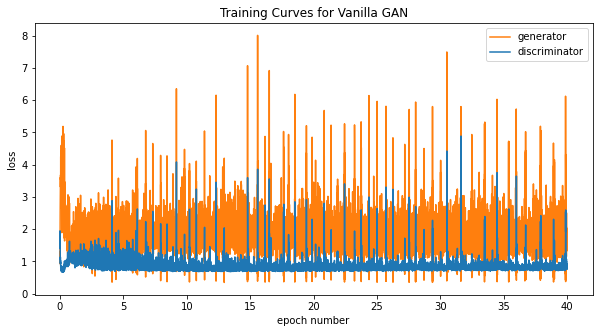

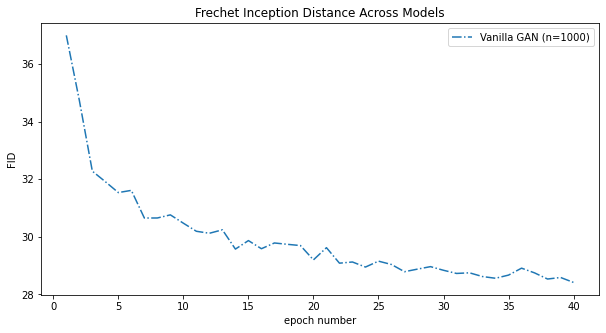

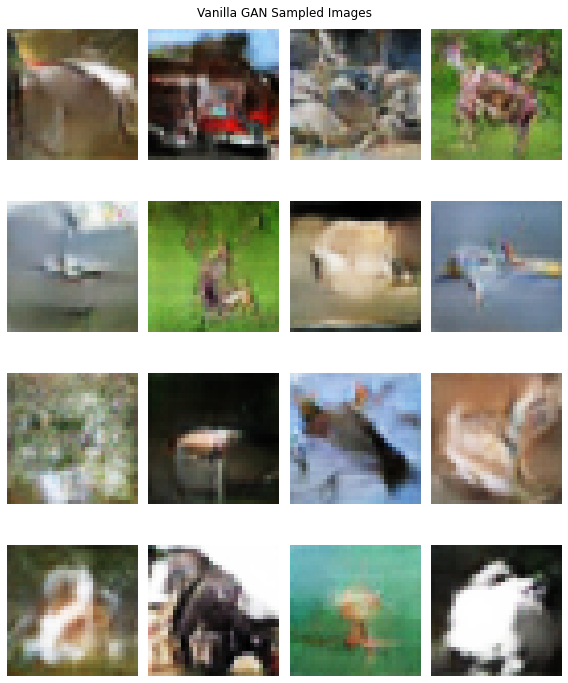

In [203]:
plot_train_summaries({"Vanilla GAN": vanilla_summ})
plot_generator_samples(vgen, title="Vanilla GAN Sampled Images")

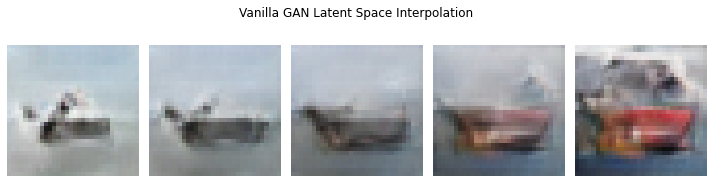

In [196]:
#plot_interpolation(vgen, title="Vanilla GAN Latent Space Interpolation")

## WGANs

Below is an implementation of the <a href="https://arxiv.org/pdf/1701.07875.pdf">Wasserstein GAN</a>, an attempt to stabilize GAN training.  Instead of the same minimax problem, we minimize the Earth Mover distance/Wasserstein loss.  The proposed algorithm crudely imposes a Lipschitz constraint by simply clipping the weights of the discriminator after each update step.  We use the same parameters specified in the paper and the same architecture as the Vanilla DCGAN (the only difference is that we remove the final sigmoid layer, as the objective function $f$ in the Wasserstein loss is not constrained to $[0, 1]$.

In [22]:
# Functions to train a WGAN

def wasserstein_loss(which_model, device, lambda_=10):
    """Returns a function to compute an empirical estimate of the Wasserstein
       loss between the true data-generating distribution P_real and
       the generated distribution P_model over parallel batches x_real and x_model.
       
       This metric is optimized by a minimax operation, first maximizing over the
       discriminator weights, then minimizing over the generator weights.
       
       Returns:
       - if which_model = 'dis': returns function (D(x_model), D(x_real)) -> scalar
       - if which_model = 'gen': returns function (D(x_model)) -> scalar
         Both functions are returned in the form of minimization problems."""
    
    if which_model == 'dis':
        return lambda d_real, d_model: torch.mean(d_real - d_model).to(device)
    elif which_model == 'gen':
        return lambda d_model: -torch.mean(d_model).to(device)
    else: 
        raise ValueError("Argument `which_model` is not a valid value")
        

def clip_weights(model, clip):
    """Clips all weights in model to bounding box [-clip, clip]."""
    
    for param in model.parameters():
        param.data.clamp_(-clip, clip)

In [23]:
def train_WGAN(gen, dis, train_set, test_set,
                num_epochs=100, dg_ratio=5, batch_size=64,
                use_cuda=True, print_every=1, train_summ=None,
                calc_fid=True, fid_samples=1000):
    """Simultaneously trains generator and discriminator by minimax optimization of
       an estimate of the Earth-Mover/Wasserstein loss induced by weight clipping
       between the the true distribution and the model's distribution.
       Uses RMSProp, with parameters defined in the original WGAN paper.
       Latent codes Z are drawn from a standard normal prior.
       
       Parameters
       - num_epochs: the number of training epochs over the dataset
       - dg_ratio: the ratio of discriminator batches to generator batches
       - batch_size: the train_set batch size passed into discriminator
                     (for each real batch, an equal-sized batch is generated by generator)
       - train_summ: summary dictionary produced by previous function call;
                     use to continue training while maintaining previous history
       - fid_samples: the number of generated samples to calculate the FID
                      (if pre-computed `train_summ` is passed in, this will be ignored)
    """
    
    # Move to GPU if possible; batches get moved as needed to save on memory
    device = "cuda:0" if use_cuda and torch.cuda.is_available() else "cpu"
    
    criterion_dis = wasserstein_loss("dis", device)
    criterion_gen = wasserstein_loss("gen", device)
    optimizer_dis = torch.optim.RMSprop(dis.parameters(), lr=5e-5)
    optimizer_gen = torch.optim.RMSprop(gen.parameters(), lr=5e-5)
    
    # Initialize a dictionary summarizing training, if one not provided
    if train_summ is None:
        train_summ = {'loss_dis': [],  # one per batch
                      'loss_gen': [],  # one per batch
                      'fid': [],       # one per epoch
                      'num_epochs': num_epochs,
                      'fid_samples': fid_samples}
    else: train_summ['num_epochs'] += num_epochs
    
    loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
    # Keep a global count of how many discriminator steps happen per generator step
    # because dg_ratio may not divide evenly into batch_size
    dis_count = 0
    for epoch in range(num_epochs):
        
        # Only let models be in training mode in this block
        gen.train()
        dis.train()
        
        for X, y in loader:
            z = torch.randn((X.shape[0], gen.z_len)).to(device)
            X = X.clone().to(device, non_blocking=True)
            
            # Discriminator trains each batch
            optimizer_dis.zero_grad()
            loss_dis = criterion_dis(dis(gen(z)), dis(X))
            loss_dis.backward()
            optimizer_dis.step()
            dis_count += 1
            train_summ['loss_dis'].append(loss_dis.detach().cpu().item())
            
            # Clip the weights of the discriminator to enfore Lipschitz continuity
            clip_weights(dis, 0.01)
            
            # Generator trains if enough discriminator passes have gone through
            if dis_count >= dg_ratio:
                optimizer_gen.zero_grad()
                loss_gen = criterion_gen(dis(gen(z)))
                loss_gen.backward()
                optimizer_gen.step()
                dis_count = 0
                train_summ['loss_gen'].append(loss_gen.detach().cpu().item())
        
        # Set to evaluation mode upon exit, since we don't need them to train anymore
        gen.eval()
        dis.eval()
        
        # Calculate the FID for generator
        if calc_fid:
            train_summ['fid'].append(eval_gen(gen, *cifar_stats["train_stats"],
                                              num_samples=fid_samples, use_cuda=use_cuda))
        
        # Evaluate how the model is performing on test set after a full epoch
        if (epoch+1) % print_every == 0:
            print(f"- EPOCH {epoch+1}:" +
                  f"\n  discriminator loss = {loss_dis}" +
                  f"\n      generator loss = {loss_gen}" +
                  "\n----------------------------------")
    
    assert not gen.training and not dis.training
    return train_summ

In [155]:
# Functions to modify DCGAN discriminator for WGAN training

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)
    
def modify_dis(dis, use_cuda=False, drop_batch=False):
    """Modifies a DCDiscriminator object for WGAN training by
       replacing final down-convolution with a flattening operation and
       a fully-connected layer with no final activation.
       Returns the final module object loaded onto the proper device."""
    
    assert type(dis) is DCDiscriminator, "Can only modify a DCDiscriminator module"
    device = "cuda:0" if use_cuda and torch.cuda.is_available() else "cpu"
    dis.conv_layers[8] = nn.Flatten()
    dis.conv_layers[9] = nn.Linear(256 * 4 * 4, 1)
    if drop_batch:
        for i in [3, 6]:
            dis.conv_layers[i] = nn.Identity()
            
    dis.to(device)
    return dis

In [156]:
gen = DCGenerator().cuda()
# Modify the architecture for WGAN
dis = modify_dis(DCDiscriminator(), use_cuda=True)

train_set = CIFARDataset().load([f"data/data_batch_{n}" for n in range(1, 6)])
test_set = CIFARDataset().load(["data/test_batch"])

In [157]:
#%time wgan_summ = train_WGAN(gen, dis, train_set, test_set, num_epochs=1, \
                             #train_summ=None, use_cuda=True, calc_fid=True, print_every=5)

In [158]:
#plot_train_summaries({"WGAN": wgan_summ})
#plot_generator_samples(wgen, title="WGAN Sampled Images")

In [159]:
#plot_interpolation(wgen, title="WGAN + Weight Clipping Latent Space Interpolation")

### Improved WGANs

For the sake of comparison, we also implement the <a href="https://arxiv.org/pdf/1704.00028.pdf">improved WGAN</a> design, since weight clipping has been shown to cause a lot of issues in training.  This uses an algorithm with enforces the Lipschitz constraint by penalizing the gradient.  The generator/discriminator architectures are the same as the above, and we use the Adam optimizer with the same hyperparameters as the paper which proposed this algorithm.

In [160]:
# Functions to train an improved WGAN

def penalized_wasserstein_loss(which_model, device, penalty=10):
    """Returns a function to compute an empirical estimate of the gradient-penalized
       loss between the true data-generating distribution P_real and
       the generated distribution P_model over parallel batches x_real and x_model.
       
       This metric is optimized by a minimax operation, first maximizing over the
       discriminator weights, then minimizing over the generator weights.
       
       Returns:
       - if which_model = 'dis': returns function (D(x_model), D(x_real), grad_norm) -> scalar
       (There is no penalized generator loss; just use normal Wasserstein for this)."""
    
    if which_model == 'dis':
        # We maximize the discriminator loss, so take negative here
        return lambda d_model, d_real, grad_norm: \
            torch.mean(d_model - d_real + lamb*(grad_norm - 1)**2).to(device)
    else: 
        raise ValueError("Argument `which_model` is not a valid value")

        
def image_grad_norm(x, module, print_grad=False):
    """Helper function.  Computes the gradient of a scalar-valued nn.Module output
       with respect to a multidimensional input, and returns the scalar-valued
       Frobenius norm of this matrix for each sample.
       i.e., if shape of x (batch_size, p) -> shape of return is (batch_size, 1)"""
    
    # Autograd computes Jacobian-vector product J^T @ v
    # If we repeat input along dim=1, and let v = identity matrix, .backwards()
    # will return the Jacobian wrt input across all batch samples very quickly
    # This is essentially just vectorizing the normal scalar .backwards()
    x_flat = x.clone().view(x.shape[0], -1)    # flatten to make gradient easier
    x_flat.requires_grad_(True)
    x_flat.retain_grad()
    
    y = module(x_flat.view(*x.shape)).flatten()
    identity = torch.ones(x.shape[0], device=y.device)
    # shape: (batch_size, input_size) - gradient on dim=1
    grad = torch.autograd.grad(y, x_flat, identity,
                               create_graph=True, only_inputs=True)[0]
    grad_norm = torch.sqrt(torch.sum(grad**2, dim=1)).unsqueeze(1)
    
    if print_grad: print(grad)
    return grad_norm

In [161]:
# Test that the gradient calculation works

class ToyModule(nn.Module):
    def forward(self, x):
        return (x[:, 0]**2 - 5*x[:, 1] + 7*x[:, 2]).unsqueeze(1)
    
x = torch.tensor([[8., 3., 1.], [2., 3., 4.]], requires_grad=True)
toy = ToyModule()
y = toy(x)
image_grad_norm(x, toy, True)

tensor([[16., -5.,  7.],
        [ 4., -5.,  7.]], grad_fn=<ViewBackward>)


tensor([[18.1659],
        [ 9.4868]], grad_fn=<UnsqueezeBackward0>)

In [162]:
# Test that the gradient function works for CUDA devices
gen = DCGenerator().cuda()
dis = modify_dis(DCDiscriminator(), use_cuda=True)
z_test = torch.randn(1000, 100).cuda()
X = train_set[:1000][0].cuda()

gen_z = gen(z_test)
epsilon = torch.rand(1).item()
gen_z_interp = epsilon * X + (1 - epsilon) * gen_z
print(gen_z_interp.device)

image_grad_norm(gen_z_interp, dis).shape

cuda:0


torch.Size([1000, 1])

In [167]:
def train_IWGAN(gen, dis, train_set, test_set,
                num_epochs=100, dg_ratio=5, batch_size=64,
                use_cuda=True, print_every=1, train_summ=None,
                calc_fid=True, fid_samples=1000):
    """Simultaneously trains generator and discriminator by minimax optimization of
       an estimate of the Earth-Mover/Wasserstein loss induced by weight clipping
       between the the true distribution and the model's distribution.
       Uses RMSProp, with parameters defined in the original WGAN paper.
       Latent codes Z are drawn from a standard normal prior.
       
       Parameters
       - num_epochs: the number of training epochs over the dataset
       - dg_ratio: the ratio of discriminator batches to generator batches
       - batch_size: the train_set batch size passed into discriminator
                     (for each real batch, an equal-sized batch is generated by generator)
       - train_summ: summary dictionary produced by previous function call;
                     use to continue training while maintaining previous history
       - fid_samples: the number of generated samples to calculate the FID
                      (if pre-computed `train_summ` is passed in, this will be ignored)
    """
    
    # Move to GPU if possible; batches get moved as needed to save on memory
    device = "cuda:0" if use_cuda and torch.cuda.is_available() else "cpu"
    
    criterion_dis = penalized_wasserstein_loss("dis", device, penalty=10)
    criterion_gen = wasserstein_loss("gen", device)
    optimizer_dis = torch.optim.Adam(dis.parameters(), lr=0.0001, betas=(0, 0.9))
    optimizer_gen = torch.optim.Adam(gen.parameters(), lr=0.0001, betas=(0, 0.9))
    
    # Initialize a dictionary summarizing training, if one not provided
    if train_summ is None:
        train_summ = {'loss_dis': [],  # one per batch
                      'loss_gen': [],  # one per batch
                      'fid': [],       # one per epoch
                      'num_epochs': num_epochs,
                      'fid_samples': fid_samples}
    else: train_summ['num_epochs'] += num_epochs
    
    loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
    # Keep a global count of how many discriminator steps happen per generator step
    # because dg_ratio may not divide evenly into batch_size
    dis_count = 0
    for epoch in range(num_epochs):
        
        # Only let models be in training mode in this block
        gen.train()
        dis.train()
        
        for X, y in loader:
            z = torch.randn((X.shape[0], gen.z_len)).to(device)
            X = X.clone().to(device, non_blocking=True)

            # Discriminator trains each batch
            optimizer_dis.zero_grad()
            gen_z = gen(z)
            # Per the algorithm, mix in real data with generated data via convex combination
            epsilon = torch.rand(1).item()
            gen_z_interp = epsilon * X.detach() + (1 - epsilon) * gen_z.detach()
            # Also calculate gradient of discriminator
            # with respect to this interpreted image set
            grad_norm = image_grad_norm(gen_z_interp, dis)
            #print(torch.mean(grad_norm).item())

            loss_dis = criterion_dis(dis(gen_z), dis(X), grad_norm)
            loss_dis.backward()
            optimizer_dis.step()
            dis_count += 1
            train_summ['loss_dis'].append(loss_dis.detach().cpu().item())

            # Generator trains if enough discriminator passes have gone through
            if dis_count >= dg_ratio:
                optimizer_gen.zero_grad()
                loss_gen = criterion_gen(dis(gen(z)))
                loss_gen.backward()
                optimizer_gen.step()
                dis_count = 0
                train_summ['loss_gen'].append(loss_gen.detach().cpu().item())
        
        # Set to evaluation mode upon exit, since we don't need them to train anymore
        gen.eval()
        dis.eval()
        
        # Calculate the FID for generator
        if calc_fid:
            train_summ['fid'].append(eval_gen(gen, *cifar_stats["train_stats"],
                                              num_samples=fid_samples, use_cuda=use_cuda))
        
        # Evaluate how the model is performing on test set after a full epoch
        if (epoch+1) % print_every == 0:
            print(f"- EPOCH {epoch+1}:" +
                  f"\n  discriminator loss = {loss_dis}" +
                  f"\n      generator loss = {loss_gen}" +
                  "\n----------------------------------")
    
    assert not gen.training and not dis.training
    return train_summ

In [164]:
gen = DCGenerator().cuda()
# Modify the architecture for WGAN (including dropping batch norms)
dis = modify_dis(DCDiscriminator(), use_cuda=True, drop_batch=True)

train_set = CIFARDataset().load([f"data/data_batch_{n}" for n in range(1, 6)])
test_set = CIFARDataset().load(["data/test_batch"])

In [184]:
%time iwgan_summ = train_IWGAN(gen, dis, train_set, test_set, num_epochs=30, dg_ratio=5, \
                               train_summ=iwgan_summ, use_cuda=True, calc_fid=True, print_every=5)

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Fold 1: 31.756830066754446
Fold 1: 31.173983018939623
Fold 1: 31.816402292848892
Fold 1: 31.197381726585718
Fold 1: 31.477554398294217
- EPOCH 5:
  discriminator loss = -1.925546407699585
      generator loss = 3.0875329971313477
----------------------------------
Fold 1: 31.49547452912418
Fold 1: 31.434591767611494
Fold 1: 31.33444871202974
Fold 1: 31.54559612034066
Fold 1: 31.39401585371371
- EPOCH 10:
  discriminator loss = -1.5586535930633545
      generator loss = -0.4411911368370056
----------------------------------
Fold 1: 31.522194429950844
Fold 1: 31.58777308083438
Fold 1: 31.444824423248548
Fold 1: 31.868031075235933
Fold 1: 31.5080583021915
- EPOCH 15:
  discriminator loss = -2.6085205078125
      generator loss = 2.9785923957824707
----------------------------------
Fold 1: 31.383113753068784
Fold 1: 31.420068648155933
Fold 1: 31.58884893154479
Fold 1: 31.988282344894543
Fold 1: 31.51435190180311
- EPOCH 20:
  discriminator loss = -2.3978803157806396
      generator loss =

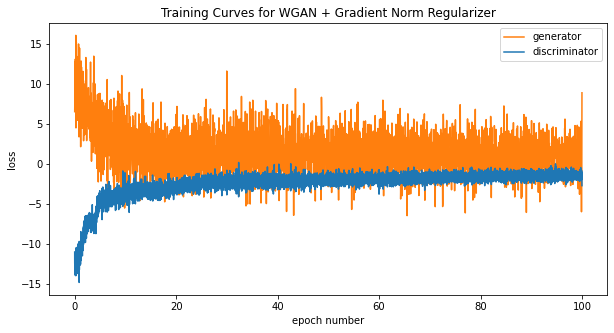

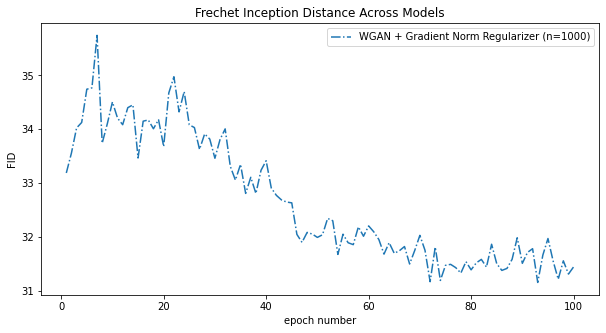

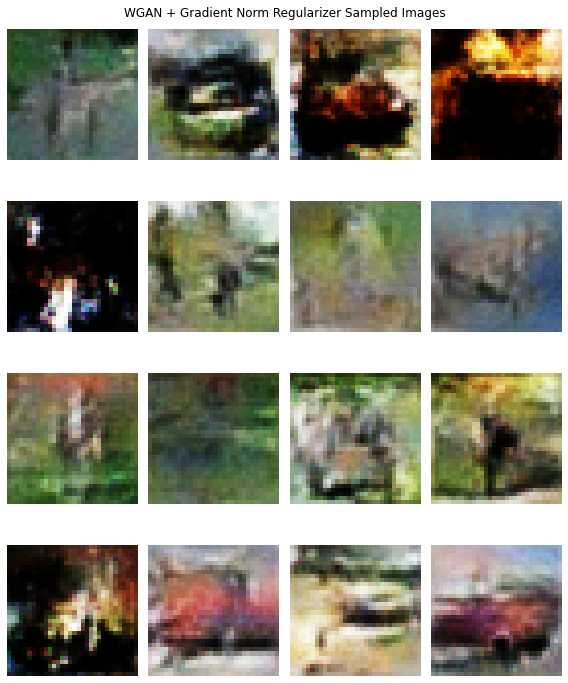

In [204]:
plot_train_summaries({"WGAN + Gradient Norm Regularizer": iwgan_summ})
plot_generator_samples(gen, title="WGAN + Gradient Norm Regularizer Sampled Images")

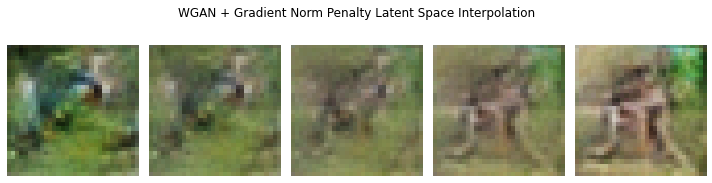

In [212]:
plot_interpolation(wgen, title="WGAN + Gradient Norm Penalty Latent Space Interpolation")

## Appendix: Loading Stored Models

Just a preset spot here to load and save models as we move around on the notebook

In [208]:
# Can store trained models like this

# VANILLA DCGAN
#enpickle(vanilla_summ, "models/vanilla_summ")
#torch.save(gen, "models/vanilla_gen")
#torch.save(dis, "models/vanilla_dis")

#vgen = torch.load("models/vanilla_gen")
#vdis = torch.load("models/vanilla_dis")
#vanilla_summ = unpickle("models/vanilla_summ")


# WASSERSTEIN DCGAN
#enpickle(wgan_summ, "models/wgan_summ")
#torch.save(gen, "models/wgan_gen")
#torch.save(dis, "models/wgan_dis")

#wgen = torch.load("models/wgan_gen")
#wdis = torch.load("models/wgan_dis")
#wgan_summ = unpickle("models/wgan_summ")


# IMPROVED WASSERSTEIN DCGAN
enpickle(iwgan_summ, "models/iwgan_summ")
torch.save(gen, "models/iwgan_gen")
torch.save(dis, "models/iwgan_dis")

#iwgen = torch.load("models/iwgan_gen")
#iwdis = torch.load("models/iwgan_dis")
#iwgan_summ = unpickle("models/iwgan_summ")

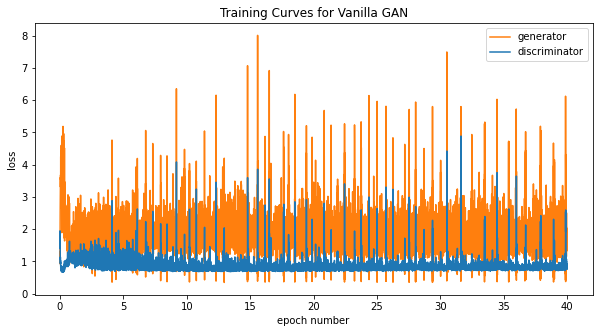

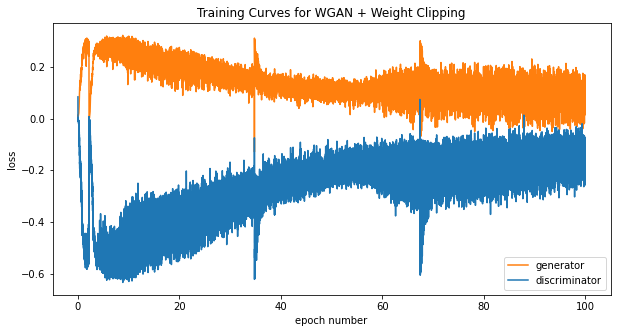

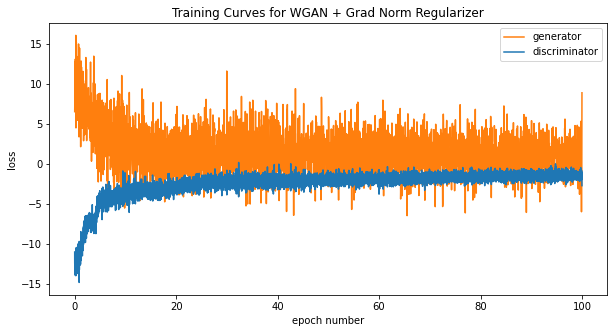

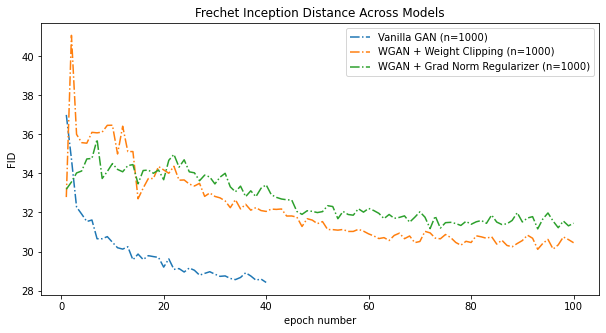

In [205]:
plot_train_summaries({"Vanilla GAN": vanilla_summ,
                      "WGAN + Weight Clipping": wgan_summ,
                      "WGAN + Grad Norm Regularizer": iwgan_summ})

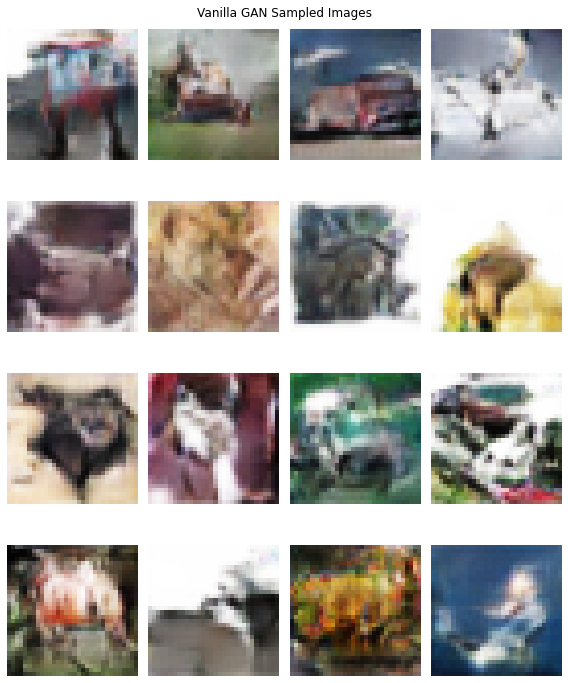

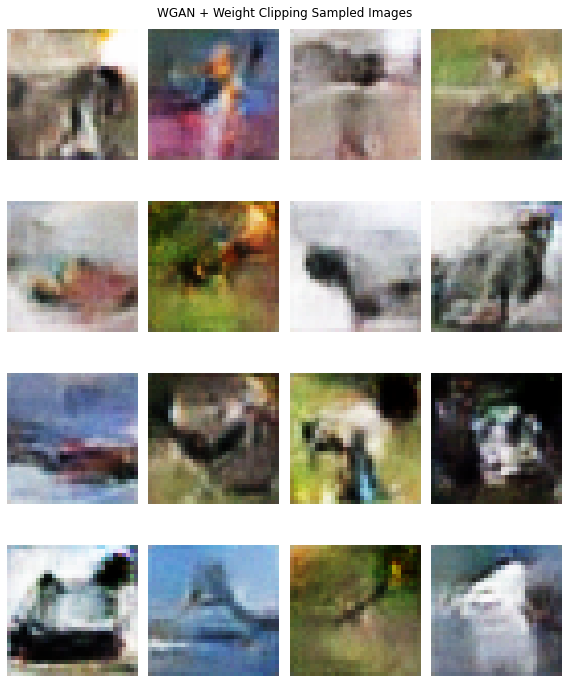

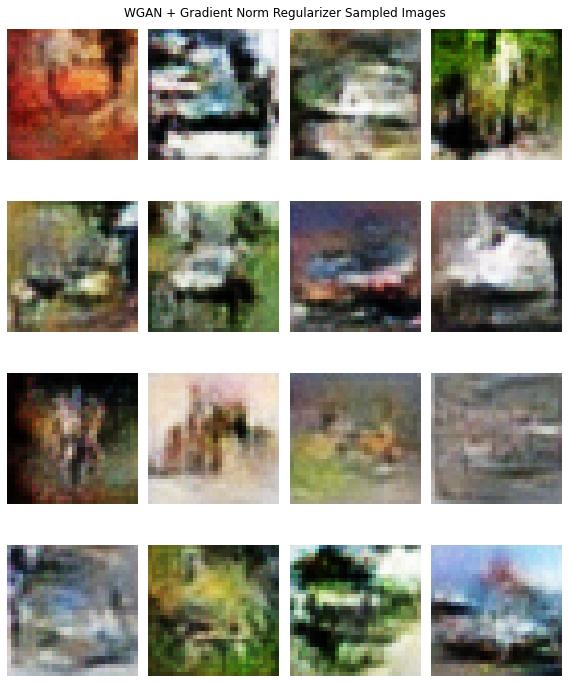

In [191]:
plot_generator_samples(vgen, title="Vanilla GAN Sampled Images")
plot_generator_samples(wgen, title="WGAN + Weight Clipping Sampled Images")
plot_generator_samples(gen, title="WGAN + Gradient Norm Regularizer Sampled Images")